In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [28]:
import os
from glob import glob
import numpy as np
import pandas as pd

## Loading The Dataset

In [12]:
PATH='data\\imdb\\'
names = ['neg','pos']

In [13]:
# a function that will open each text file and append the text to a list with the label (0,1) based on index (neg,pos)
def texts_labels_from_folders(path, folders):
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        for fname in glob(os.path.join(path, label, '*.*')):
            try:
                texts.append(open(fname, 'r').read())
            except UnicodeDecodeError:
                texts.append(open(fname, 'r',encoding = 'utf-8').read())
            labels.append(idx)
    return texts, np.array(labels).astype(np.int64)

In [14]:
#loading training set and labels
trn,trn_y = texts_labels_from_folders(f'{PATH}train',names)

In [15]:
#loading the validation data set and labels
val,val_y = texts_labels_from_folders(f'{PATH}test',names)

In [23]:
#checking the datasets
print(trn[0],'\n',trn_y[0],'\n',val[0],'\n',val_y[0],'\n')

Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly. 
 0 
 Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I

## Visualization

In [37]:
df = pd.DataFrame(list(zip(trn,trn_y)),columns=['reviews','labels'])

In [46]:
df.head()

,reviews,labels
0,Story of a man who has unnatural feelings for ...,0
1,Airport '77 starts as a brand new luxury 747 p...,0
2,This film lacked something I couldn't put my f...,0
3,"Sorry everyone,,, I know this is supposed to b...",0
4,When I was little my parents took me along to ...,0


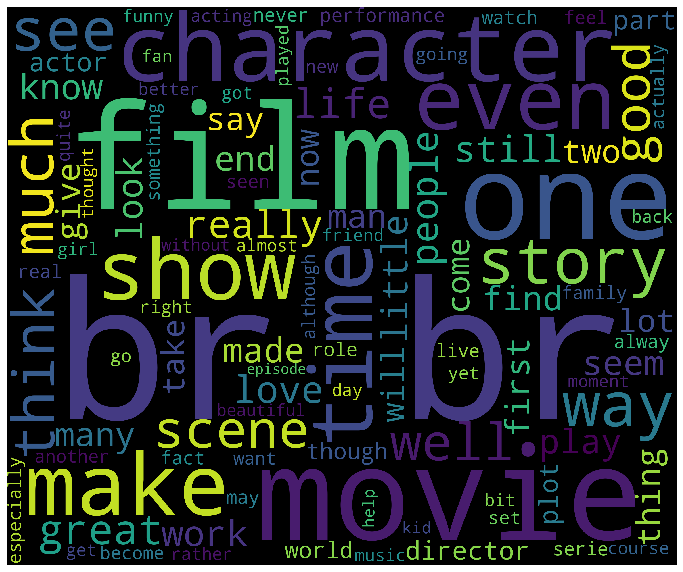

In [44]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

# Defining cloud for positive
df_cloud = df[df.labels == 1]

words = " ".join(df_cloud.reviews)
split_words = " ".join([word for word in words.split()])

# Creating cloud
wordcloud = WordCloud(
    stopwords=STOPWORDS,
    width=3000,
    height=2500,
    max_words=100,
).generate(split_words)

plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

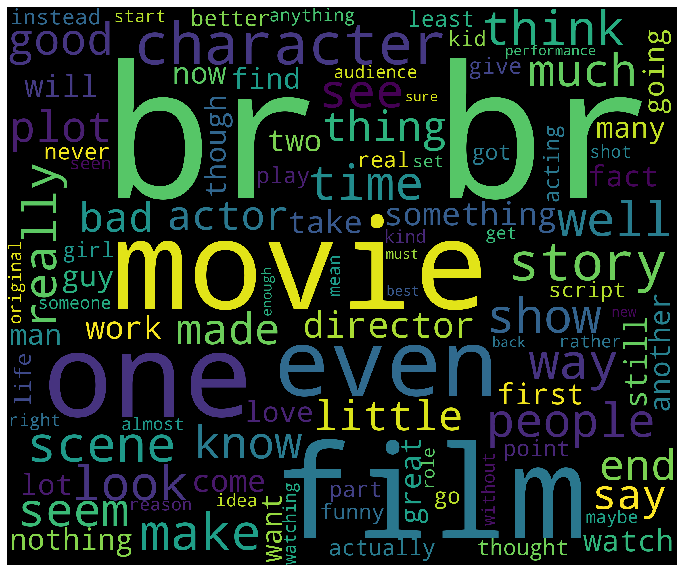

In [45]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

# Defining cloud for negative reviews
df_cloud = df[df.labels == 0]

words = " ".join(df_cloud.reviews)
split_words = " ".join([word for word in words.split()])

# Creating cloud
wordcloud = WordCloud(
    stopwords=STOPWORDS,
    width=3000,
    height=2500,
    max_words=100,
).generate(split_words)

plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

it seems like the most common words in positive and negative reviews are generic words

## Processing The Dataset

### Converting to Bag of Words Format

In [47]:
import re,string

creating a tokenizer

In [50]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

In [52]:
veczr = CountVectorizer(tokenizer=tokenize)

creating a bag of words with unigrams

In [53]:
trn_term_doc = veczr.fit_transform(trn)
val_term_doc = veczr.transform(val)

### Naive Bayes

$r = \log \frac{\text{ratio of feature $f$ in positive documents}}{\text{ratio of feature $f$ in negative documents}}$

$b = \log \frac{\text{probability of a postive document}}{\text{probability of a negative document}}$

In [65]:
def pr(y_i):
    p = x[y==y_i].sum(0) #sum of every column (word)
    return (p+1) / ((y==y_i).sum()+1) #sum of every word over the sum of positive/negative documents
#the probability that each word will appear in a positive/negative document

In [66]:
x=trn_term_doc
y=trn_y

In [67]:
r = np.log(pr(1)/pr(0))
b = np.log((y==1).mean() / (y==0).mean())

since we have used the logs of the fraction we can now matrix multiply the term document and the prior and then add the posteriors

In [68]:
pre_preds = val_term_doc @ r.reshape(-1,1) + b
preds = pre_preds.T>0
(preds==val_y).mean() #accuracy

0.81668

we will try a binzarized version (ignoring the counts)

In [72]:
x = trn_term_doc.sign()
r = np.log(pr(1)/pr(0))

In [73]:
pre_preds = val_term_doc.sign() @ r.reshape(-1,1) + b
preds = pre_preds.T>0
(preds==val_y).mean() #accuracy

0.83012

### Logestic Regression

In [75]:
from sklearn.linear_model import LogisticRegression

In [77]:
x=trn_term_doc
y=trn_y
m = LogisticRegression(dual=True)
m.fit(x, y)
preds = m.predict(val_term_doc)
(preds==val_y).mean()

0.87104

binarized version

In [78]:
x = trn_term_doc.sign()
m = LogisticRegression(dual=True)
m.fit(x, y)
preds = m.predict(val_term_doc.sign())
(preds==val_y).mean()

0.8742

adding regularization

In [79]:
x=trn_term_doc
y=trn_y
m = LogisticRegression(dual=True,C=0.01)
m.fit(x, y)
preds = m.predict(val_term_doc)
(preds==val_y).mean()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.88236

regularized binarized version

In [81]:
x = trn_term_doc.sign()
m = LogisticRegression(dual=True, C=0.01)
m.fit(x, y)
preds = m.predict(val_term_doc.sign())
(preds==val_y).mean()

0.87976

### Bigrams with Logistic Regression

In [82]:
veczr =  CountVectorizer(ngram_range=(1,2), tokenizer=tokenize, max_features=800000)
trn_term_doc = veczr.fit_transform(trn)
val_term_doc = veczr.transform(val)

In [83]:
vocab = veczr.get_feature_names()

In [87]:
vocab[200000:200005]

['heavy going', 'heavy gold', 'heavy gore', 'heavy handed', 'heavy handedness']

In [88]:
x=trn_term_doc
y=trn_y
m = LogisticRegression(dual=True,C=0.01)
m.fit(x, y)
preds = m.predict(val_term_doc)
(preds==val_y).mean()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.896

### Trigrams with Logistic Regression

In [89]:
veczr =  CountVectorizer(ngram_range=(1,3), tokenizer=tokenize, max_features=800000)
trn_term_doc = veczr.fit_transform(trn)
val_term_doc = veczr.transform(val)

In [90]:
vocab = veczr.get_feature_names()

In [92]:
vocab[400000:400005]

['just drove', 'just drove me', 'just drunk', 'just due', 'just due .']

In [95]:
x=trn_term_doc
y=trn_y
m = LogisticRegression(dual=True,C=0.01)
m.fit(x, y)
preds = m.predict(val_term_doc)
(preds==val_y).mean()

0.89772

Regularized Binarized Trigrams

In [96]:
x = trn_term_doc.sign()
m = LogisticRegression(dual=True, C=0.01)
m.fit(x, y)
preds = m.predict(val_term_doc.sign())
(preds==val_y).mean()

0.89928

### Naive Bayes with Logistic Regression

we will multiply our term documents with r from naive bayes as sort of bias while doing Logistic Regression, in this manner we will combine theory with learning and decrease the regularization a bit to achieve better results

In [98]:
x=trn_term_doc
y=trn_y
r = np.log(pr(1)/pr(0))
x_nb = trn_term_doc.multiply(r)

In [101]:
m = LogisticRegression(dual=True, C=0.1)
m.fit(x_nb, y);

val_x_nb = val_term_doc.multiply(r)
preds = m.predict(val_x_nb)
(preds.T==val_y).mean()

0.91504

the binarized regularized version

In [102]:
x = trn_term_doc.sign()
r = np.log(pr(1)/pr(0))
x_nb = trn_term_doc.multiply(r)

In [122]:
m = LogisticRegression(dual=True, C=0.105, solver = 'liblinear')
m.fit(x_nb, y);

val_x_nb = val_term_doc.sign().multiply(r)
preds = m.predict(val_x_nb)
(preds.T==val_y).mean()

0.9184

## Summary of Results

so this our final model **(Trigrams Binarized NB+Losgistic Regression with Regularization)** with an accuracy of 91.84%

In [123]:
m = LogisticRegression(dual=True, C=0.105, solver = 'liblinear')
m.fit(x_nb, y);

val_x_nb = val_term_doc.sign().multiply(r)
preds = m.predict(val_x_nb)
(preds.T==val_y).mean()

0.9184

## Recommendations

**Apply Word Embeddings and Recurrent Neural Network and compare the results**